# Plot escape profiles for Omicron BA2 background MAP
This Python Jupyter notebook plots escape profiles for antibodies and sera.

## Import and read configuration / data
Import Python modules:

In [1]:
import multiprocessing
import os

import Bio.SeqIO

import dms_variants
import dms_variants.constants
import dms_variants.utils

import dmslogo
from dmslogo.colorschemes import CBPALETTE
import dmslogo.utils

from IPython.display import display, HTML, Image

import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt

import numpy

import pandas as pd

from plotnine import *

import pdb_prot_align.colorschemes

import yaml

%matplotlib inline

Versions of key software:

In [2]:
print(f"Using `dmslogo` version {dmslogo.__version__}")
print(f"Using `dms_variants` version {dms_variants.__version__}")

Using `dmslogo` version 0.6.3
Using `dms_variants` version 1.4.3


Read the configuration file:

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [4]:
os.makedirs(config['escape_profiles_dir_Omicron_EG5'], exist_ok=True)

Extract from configuration what we will use as the site- and mutation-level metrics:

In [5]:
site_metric = config['site_metric']
mut_metric = config['mut_metric']

print(f"At site level, quantifying selection by {site_metric}")
print(f"At mutation level, quantify selection by {mut_metric}")

At site level, quantifying selection by site_total_escape_frac_single_mut
At mutation level, quantify selection by mut_escape_frac_single_mut


Read the sites of "strong escape" for each antibody / sera.
These auto-identified sites are what we plot by default for each escape profile:

In [6]:
print(f"Reading sites of strong escape from {config['strong_escape_sites_Omicron_EG5']}")

strong_escape_sites = pd.read_csv(config['strong_escape_sites_Omicron_EG5'])

Reading sites of strong escape from results/escape_profiles/strong_escape_sites_Omicron_EG5.csv


## Read and pad escape fractions data frame
Read the escape fractions.
We only retain the **average** of the libraries for plotting here, not the individual libraries.
Also, we work in the full-Spike rather than RBD numbering, which means we use `label_site` as `site` (and so rename as such below):

In [7]:
print(f"Reading escape fractions from {config['escape_fracs_Omicron_EG5']}")
escape_fracs = (pd.read_csv(config['escape_fracs_Omicron_EG5'])
                .query('library == "average"')
                .drop(columns=['site', 'selection', 'library'])
                .rename(columns={'label_site': 'site'})
                )
print('First few lines of escape-fraction data frame with sample-information added:')
display(HTML(escape_fracs.head().to_html(index=False)))

Reading escape fractions from results/escape_scores/escape_fracs_Omicron_EG5.csv
First few lines of escape-fraction data frame with sample-information added:


condition,site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_single_mut,site_total_escape_frac_single_mut,site_avg_escape_frac_single_mut,nlibs,n_single_mut_measurements
S2K146_121,331,N,-,E,331,0.2668,5.294,0.2647,2,25
S2K146_121,331,N,A,E,331,0.2703,5.294,0.2647,2,25
S2K146_121,331,N,C,E,331,0.2843,5.294,0.2647,2,30
S2K146_121,331,N,D,E,331,0.2261,5.294,0.2647,2,30
S2K146_121,331,N,E,E,331,0.2750,5.294,0.2647,2,31


Some sites / mutations are totally missing in the `escape_fracs` data frame.
For plotting with `dmslogo`, we need to pad these missing sites to be zero:

In [8]:
# make "padding" data frame covering all conditions, sites, and mutations
first_site = escape_fracs['site'].min()
last_site = escape_fracs['site'].max()
mutations = escape_fracs['mutation'].unique()
pad_df = pd.concat([pd.DataFrame({'condition': condition,
                                  'site': site,
                                  'mutation': mutations})
                    for condition in escape_fracs['condition'].unique()
                    for site in range(first_site, last_site + 1)])

# need to read in wildtype and map site to wildtype
wt_prot = str(Bio.SeqIO.read(config['wildtype_sequence_Omicron_EG5'], 'fasta').seq.translate())
assert len(wt_prot) == last_site - first_site + 1
site_to_wt = {site: wt_prot[site - first_site] for site in range(first_site, last_site + 1)}
for site, wt in escape_fracs.set_index('site')['wildtype'].to_dict().items():
    if wt != site_to_wt[site]:
        raise ValueError(site, wt, site_to_wt[site])

# pad escape fracs data frame
escape_fracs_padded = (
    escape_fracs
    [['condition', 'site', 'mutation', site_metric, mut_metric]]
    .merge(pad_df, how='outer')
    .fillna(0)
    .assign(wildtype=lambda x: x['site'].map(site_to_wt),
            wt_site=lambda x: x['wildtype'] + x['site'].astype(str))
    .assign(**{site_metric: lambda x: x.groupby(['condition', 'site'])[site_metric].transform('max')})
    )

## Color by deep mutational scanning data
We add columns to the data frame that enable coloring of the logo plots by the deep mutational scanning measurements of binding or expression.
We choose a color scheme that spans the min and maximum values for all letters with non-zero height (the mutation-level metric > 0).
We also write out the scale bar for this coloring.

Importantly, **note that as long as `clip_vals_gt_0` is set to `True`, then all DMS values greater than 0 (beneficial mutations) are set to zero**. For publications, the scale bar should be manually edited to change "0" to ">0" to reflect this fact.

Reading DMS data from results/prior_DMS_data/mutant_ACE2binding_expression.csv

bind ranges from -3.0 to 0.0, here is the scale bar, which is being saved to results/escape_profiles/Omicron_EG5/bind_scalebar_horizontal.pdf


/scratch/local/u6042467/599553/ipykernel_1630388/375458195.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


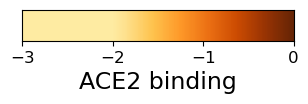


bind ranges from -3.0 to 0.0, here is the scale bar, which is being saved to results/escape_profiles/Omicron_EG5/bind_scalebar_vertical.pdf


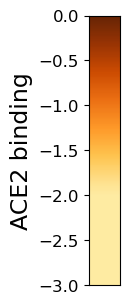

Saving DMS color scheme to results/escape_profiles/Omicron_EG5/escape_profiles_dms_colors.csv

expr ranges from -0.75 to 0.0, here is the scale bar, which is being saved to results/escape_profiles/Omicron_EG5/expr_scalebar_horizontal.pdf


/scratch/local/u6042467/599553/ipykernel_1630388/375458195.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


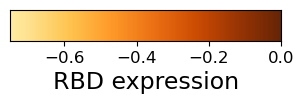


expr ranges from -0.75 to 0.0, here is the scale bar, which is being saved to results/escape_profiles/Omicron_EG5/expr_scalebar_vertical.pdf


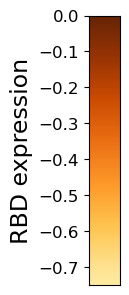

Saving DMS color scheme to results/escape_profiles/Omicron_EG5/escape_profiles_dms_colors.csv


In [9]:
mut_bind_expr_file = config['mut_bind_expr']

clip_vals_gt_0 = True  # plot DMS values > 0 as 0 (grouping beneficial and neutral)

print(f"Reading DMS data from {mut_bind_expr_file}")

# read DMS data flagging mutations with escape > 0
mut_bind_expr = (
    pd.read_csv(mut_bind_expr_file)
    .query("target == 'Omicron_EG5'")
    [['position', 'mutant', 'delta_bind', 'delta_expr']]
    .rename(columns={'position': 'site',
                     'mutant': 'mutation',
                     'delta_bind': 'bind',
                     'delta_expr': 'expr'})
    # flag mutations with mutation escape > 0
    .merge(escape_fracs_padded, how='right', validate='one_to_many', on=['site', 'mutation'])
    .assign(escape_gt_0=lambda x: x[mut_metric] > 0)
    .groupby(['site', 'mutation', 'bind', 'expr'])
    .aggregate(escape_gt_0=pd.NamedAgg('escape_gt_0', 'any'))
    .reset_index()
    .drop_duplicates()
    )

# add color for each mutation, coloring those without escape > 0 as white, and for bind coloring everything <-2 to -3 equlaly yellow
for prop in ['bind', 'expr']:

    if prop == 'bind':

        # set up color scale and draw scale bard
        min_prop = config['escape_score_min_bind_mut_Omicron_EG5']
        if clip_vals_gt_0:
            mut_bind_expr[prop] = numpy.clip(mut_bind_expr[prop], None, 0)
        max_prop = mut_bind_expr.query('escape_gt_0')[prop].max()
        # get YlOrBr color map (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html),
        # but start 20% in so not too faint: https://stackoverflow.com/a/18926541
        # for bind, we want to censor to equally yellow everything <-2. We'll do this with two sub-arrays
        # Define the parameters for the two separate linspace arrays
        start1 = 0.2
        stop1 = 0.2
        num1 = int(256*((config['escape_score_bind_Yl_threshold'] - config['escape_score_min_bind_mut_Omicron_EG5'])/(0-config['escape_score_min_bind_mut_Omicron_EG5'])))

        start2 = 0.2
        stop2 = 1.0
        num2 = 256-num1

        linspace1 = numpy.linspace(start1, stop1, num1)
        linspace2 = numpy.linspace(start2, stop2, num2)

        # Concatenate the two linspace arrays
        concatenated_linspace = numpy.concatenate((linspace1, linspace2))
        
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                name='trunc_YlOrBr',
                colors=matplotlib.cm.get_cmap('YlOrBr', lut=256)(concatenated_linspace)
                )
        colormap = pdb_prot_align.colorschemes.ValueToColorMap(
                        minvalue=min_prop,
                        maxvalue=max_prop,
                        cmap=cmap,
                        )

    else:

        # set up color scale and draw scale bard
        min_prop = mut_bind_expr.query('escape_gt_0')[prop].min()
        if clip_vals_gt_0:
            mut_bind_expr[prop] = numpy.clip(mut_bind_expr[prop], None, 0)
        max_prop = mut_bind_expr.query('escape_gt_0')[prop].max()
        # get YlOrBr color map (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html),
        # but start 20% in so not too faint: https://stackoverflow.com/a/18926541
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                name='trunc_YlOrBr',
                colors=matplotlib.cm.get_cmap('YlOrBr', lut=256)(numpy.linspace(0.2, 1, 256))
                )
        colormap = pdb_prot_align.colorschemes.ValueToColorMap(
                        minvalue=min_prop,
                        maxvalue=max_prop,
                        cmap=cmap,
                        )
         
    for orientation in ['horizontal', 'vertical']:
        scalebar_file = os.path.join(config['escape_profiles_dir_Omicron_EG5'], f"{prop}_scalebar_{orientation}.pdf")
        print(f"\n{prop} ranges from {min_prop} to {max_prop}, here is the scale bar, which is being saved to {scalebar_file}")
        fig, _ = colormap.scale_bar(orientation=orientation,
                                    label={'bind': 'ACE2 binding',
                                           'expr': 'RBD expression'}[prop])
        fig.savefig(scalebar_file, bbox_inches='tight')
        fig.savefig(os.path.splitext(scalebar_file)[0]+ '.svg', bbox_inches='tight')
        display(fig)
        plt.close(fig)

    # add color to data frame of DMS data
    mut_bind_expr[f"{prop}_color"] = mut_bind_expr.apply(lambda r: colormap.val_to_color(r[prop]) if r['escape_gt_0'] else 'white',
                                                         axis=1)
    
    # save to file the color scheme
    print(f"Saving DMS color scheme to {config['escape_profiles_dms_colors_Omicron_EG5']}")
    (mut_bind_expr
     .query('escape_gt_0')
     .drop(columns='escape_gt_0')
     .to_csv(config['escape_profiles_dms_colors_Omicron_EG5'], index=False)
     )
    
# add DMS coloring to escape fractions data frame
escape_fracs_padded = (
    escape_fracs_padded
    .drop(columns=['bind_color', 'expr_color'], errors='ignore')
    .merge(mut_bind_expr[['site', 'mutation', 'bind_color', 'expr_color']],
           how='left',
           validate='many_to_one',
           on=['site', 'mutation'])
    # assign colors that are NaN and have 0 height to be white
    .assign(bind_color=lambda x: x['bind_color'].where((x[mut_metric] != 0) | x['bind_color'].notnull(),
                                                       'white'),
            expr_color=lambda x: x['expr_color'].where((x[mut_metric] != 0) | x['expr_color'].notnull(),
                                                       'white'),
            )
    )
# check no letters have NaN colors
nan_color = (
    escape_fracs_padded[escape_fracs_padded['bind_color'].isna() | escape_fracs_padded['expr_color'].isna()]
    )
if len(nan_color):
    raise ValueError(f"The following entries lack colors:\n{nan_color}")

## Plot specified escape profiles
We have manually specified configurations for escape profiles in a YAML file:

In [10]:
print(f"Reading escape-profile configuration from {config['escape_profiles_config_Omicron_EG5']}")
with open(config['escape_profiles_config_Omicron_EG5']) as f:
    escape_profiles_config = yaml.safe_load(f)
    
print(f"Reading the site color schemes from {config['site_color_schemes']}")
site_color_schemes = pd.read_csv(config['site_color_schemes'])

Reading escape-profile configuration from data/escape_profiles_config_Omicron_EG5.yaml
Reading the site color schemes from data/site_color_schemes.csv


Now start making these plots.
We will do this in a multiprocessing queue, so first define the function that makes each actual plot:

In [11]:
def draw_profile(tup):
    """Takes single argument `tup` which is a tuple with the following elements: 
        - df: pandas.DataFrame with data of interest.
        - site_metric: site-level metric
        - show_color: highlighting color in site-level plots
        - draw_line_plot: do we draw line plot?
        - mut_metric: mutation-level metric
        - color: column with logo plot color
        - dmslogo_facet_plot_kwargs: other kwargs
        - dmslogo_draw_logo_kwargs: any kwargs for draw_logo
        - dmslogo_draw_line_kwargs: any kwargs for draw_line
        - pdffile: name of created PDF
        - pngfile: name of created PNG
        - svgfile: name of created SVG
        
    Returns 2-tuple `(pdffile, pngfile)`
    """
    (df, site_metric, show_color, draw_line_plot, mut_metric, color, dmslogo_facet_plot_kwargs,
     dmslogo_draw_logo_kwargs, dmslogo_draw_line_kwargs, pdffile, pngfile, svgfile) = tup
    fig, ax = dmslogo.facet_plot(
            data=df,
            x_col='site',
            show_col='to_show',
            gridrow_col='condition',
            share_ylim_across_rows=False,
            draw_line_kwargs=(dict({'height_col': site_metric,
                                    'ylabel': 'escape fraction',
                                    'widthscale': 1.3,
                                    'show_color': show_color
                                    },
                                   **dmslogo_draw_line_kwargs)
                              if draw_line_plot else None
                              ),
            draw_logo_kwargs=dict({'letter_height_col': mut_metric,
                                   'letter_col': 'mutation',
                                   'ylabel': 'escape fraction',
                                   'color_col': color,
                                   'xtick_col': 'wt_site',
                                   'xlabel': 'site',
                                   'shade_color_col': 'shade_color' if 'shade_color' in df.columns else None,
                                   'shade_alpha_col': 'shade_alpha' if 'shade_alpha' in df.columns else None
                                   },
                                  **dmslogo_draw_logo_kwargs,
                                  ),
            share_xlabel=True,
            share_ylabel=True,
            **dmslogo_facet_plot_kwargs,
            )
    fig.savefig(pdffile, dpi=300, transparent=True, bbox_inches='tight')
    fig.savefig(pngfile, dpi=300, transparent=True, bbox_inches='tight')
    fig.savefig(svgfile, transparent=True, bbox_inches='tight')
    plt.close(fig)
    
    return pdffile, pngfile

Now make a list of the input tuples we pass the `draw_profiles` function above for everything we want to draw:

In [12]:
draw_profile_tups = []

for name, specs in escape_profiles_config.items():
        
    # get data frame with just the conditions we want to plot, also re-naming them
    conditions_to_plot = list(specs['conditions'].keys())
    assert len(conditions_to_plot) == len(set(specs['conditions'].values()))
    assert set(conditions_to_plot).issubset(set(escape_fracs_padded['condition']))
    df = (escape_fracs_padded
          .query('condition in @conditions_to_plot')
          .assign(condition=lambda x: x['condition'].map(specs['conditions']))
          )
    
    # see if we are only plotting single-nt available mutations
    if 'single_nt_only' in specs:
        if not numpy.allclose(df[site_metric],
                              df.groupby(['condition', 'site'])[mut_metric].transform('sum'),
                              atol=1e-3,
                              rtol=1e-3):
            raise ValueError('single_nt_only plotting requires re-computation of the site metric, so it must be the '
                             'simple sum of the mutation metric')
        nt_seq = str(Bio.SeqIO.read(specs['single_nt_only'], 'genbank').seq)
        df = df.assign(site_one_index=lambda x: x['site'] - int(config['site_number_offset']))
        df = (
            df
            .assign(codon=lambda x: x['site_one_index'].map(lambda r: nt_seq[3 * (r - 1): 3 * r]),
                    codon_aa=lambda x: x['codon'].map(dms_variants.constants.CODON_TO_AA),
                    single_nt_accessible=lambda x: x.apply(
                                lambda row: dms_variants.utils.single_nt_accessible(row['codon'],
                                                                                    row['mutation'],
                                                                                    'false'),
                                axis=1)
                    )
            )
        # check nucleotide sequence encodes correct amino-acid sequence
        if any(df['wildtype'] != df['codon_aa']):
            raise ValueError('nucleotide sequence differs DMS RBD amino-acid sequence')
        # subset on mutations of interest, re-compute site metric
        df = df.query('single_nt_accessible')
        df[site_metric] = df.groupby(['condition', 'site'])[mut_metric].transform('sum')
    
    # specify order to plot
    df = df.assign(condition=lambda x: pd.Categorical(x['condition'], specs['conditions'].values(), ordered=True))
    
    # get the sites we want to show in logo plots
    sites_to_show = []
    if specs['plot_auto_identified_sites']:
        threshold = specs['plot_auto_identified_sites']
        if threshold not in strong_escape_sites['threshold'].unique():
            raise ValueError(f"invalid `plot_auto_identified_sites of {threshold}\n"
                             f"valid values are: {strong_escape_sites['threshold'].unique()}")
        sites_to_show += (strong_escape_sites
                          .query('condition in @conditions_to_plot')
                          .query('threshold == @threshold')
                          ['site']
                          .unique()
                          .tolist()
                          )
    sites_to_show += specs['add_sites']
    sites_to_show = set(sites_to_show) - set(specs['exclude_sites'])
    df = df.assign(to_show=lambda x: x['site'].isin(sites_to_show))
    
    # is there a site color scheme?
    color_col = None
    if 'site_color_scheme' in specs:
        color_col = 'color'
        if specs['site_color_scheme'] in site_color_schemes.columns:
            # color scheme specified by site
            site_colors = site_color_schemes.set_index('site')[specs['site_color_scheme']].to_dict()
            df = df.assign(color=lambda x: x['site'].map(site_colors))
        else:
            # color specified for all sites
            df = df.assign(color=specs['site_color_scheme'])
    # is there a mutation color specification?
    if 'mutation_colors' in specs:
        assert 'site_color_scheme' in specs, 'must specify site-color scheme for mutation colors'
        def mut_color(row):
            key = f"{row['mutation']}{row['site']}"
            if key in specs['mutation_colors']:
                return specs['mutation_colors'][key]
            else:
                return row[color_col]
        df = df.assign(color=lambda x: x.apply(mut_color, axis=1))
        
    # shade any sites
    if 'shade_sites' in specs:
        shade_records = []
        for condition, shade_sites in specs['shade_sites'].items():
            for site, (shade_color, shade_alpha) in shade_sites.items():
                shade_records.append((condition, site, shade_color, shade_alpha))
        shade_df = pd.DataFrame.from_records(shade_records,
                                             columns=['condition', 'site', 'shade_color', 'shade_alpha'])
        df = df.merge(shade_df,
                      on=['condition', 'site'],
                      how='left',
                      validate='many_to_one',
                      )
    
    # get any additional logo plot arguments
    if 'dmslogo_facet_plot_kwargs' in specs:
        dmslogo_facet_plot_kwargs = specs['dmslogo_facet_plot_kwargs']
    else:
        dmslogo_facet_plot_kwargs = {}
        
    # get y-axis limits, see here: https://jbloomlab.github.io/dmslogo/set_ylims.html
    if 'escape_profile_ymax' in specs:  # specific y-max set for this plot
        escape_profile_ymax_quantile = specs['escape_profile_ymax']['quantile']
        escape_profile_ymax_frac = specs['escape_profile_ymax']['frac']
        if 'min_ymax' in specs['escape_profile_ymax']:
            escape_profile_min_ymax = specs['escape_profile_ymax']['min_ymax']
        else:
            escape_profile_min_ymax = None
    else:  # use default in config
        escape_profile_ymax_quantile = config['escape_profile_ymax']['quantile']
        escape_profile_ymax_frac = config['escape_profile_ymax']['frac']
        if 'min_ymax' in config['escape_profile_ymax']:
            escape_profile_min_ymax = config['escape_profile_ymax']['min_ymax']
        else:
            escape_profile_min_ymax = None
    ylim_setter = dmslogo.utils.AxLimSetter(max_from_quantile=(escape_profile_ymax_quantile,
                                                               escape_profile_ymax_frac),
                                            datalim_pad=0.06,
                                            min_upperlim=escape_profile_min_ymax)
    ylim_setter_nopad = dmslogo.utils.AxLimSetter(max_from_quantile=(escape_profile_ymax_quantile,
                                                                     escape_profile_ymax_frac),
                                                  datalim_pad=0,
                                                  min_upperlim=escape_profile_min_ymax)
    ylims = {}
    ylims_nopad = {}  # unpadded are written to file giving min / max of logos
    for condition, condition_df in df.groupby('condition'):
        ylims[condition] = ylim_setter.get_lims(condition_df
                                                [['site', site_metric]]
                                                .drop_duplicates()
                                                [site_metric]
                                                )
        ylims_nopad[condition] = ylim_setter_nopad.get_lims(condition_df
                                                            [['site', site_metric]]
                                                            .drop_duplicates()
                                                            [site_metric]
                                                            )
    if 'set_ylims' not in dmslogo_facet_plot_kwargs:  # do not overwrite manual y-limits
        dmslogo_facet_plot_kwargs['set_ylims'] = ylims
    else:
        ylims_nopad = dmslogo_facet_plot_kwags['set_ylims']
        
    # write the ylimits
    ylims_csv = os.path.join(config['escape_profiles_dir_Omicron_EG5'], f"{name}_stackedlogo_ylims.csv")
    (
     pd.DataFrame.from_dict(ylims_nopad, orient='index', columns=['minimum', 'maximum'])
     .rename_axis('condition')
     .to_csv(ylims_csv, float_format='%.3f')
     )
        
    # draw plot for each color scheme
    colors_plotfiles = [(color_col, os.path.join(config['escape_profiles_dir_Omicron_EG5'], f"{name}_stackedlogo.pdf"))]
    if 'color_by_dms' in specs and specs['color_by_dms']:
        colors_plotfiles += [('bind_color', os.path.join(config['escape_profiles_dir_Omicron_EG5'], f"{name}_color_by_bind_stackedlogo.pdf")),
                             ('expr_color', os.path.join(config['escape_profiles_dir_Omicron_EG5'], f"{name}_color_by_expr_stackedlogo.pdf"))]
    for color, pdffile in colors_plotfiles:
        pngfile = os.path.splitext(pdffile)[0] + '.png'
        svgfile = os.path.splitext(pdffile)[0] + '.svg'
        draw_profile_tups.append((
                df, site_metric, CBPALETTE[-1],
                'draw_line_plot' not in specs or specs['draw_line_plot'],
                mut_metric, color, 
                dmslogo_facet_plot_kwargs,
                specs['dmslogo_draw_logo_kwargs'] if 'dmslogo_draw_logo_kwargs' in specs else {},
                specs['dmslogo_draw_line_kwargs'] if 'dmslogo_draw_line_kwargs' in specs else {},
                pdffile, pngfile, svgfile
                ))

Now use a multiprocessing queue to map the plotting function to the tuple arguments in the multiprocessing queue:

Drawing 9 profiles using 16 CPUs...

Plotted profile 1 to:
 results/escape_profiles/Omicron_EG5/VIR7229_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_stackedlogo.png.


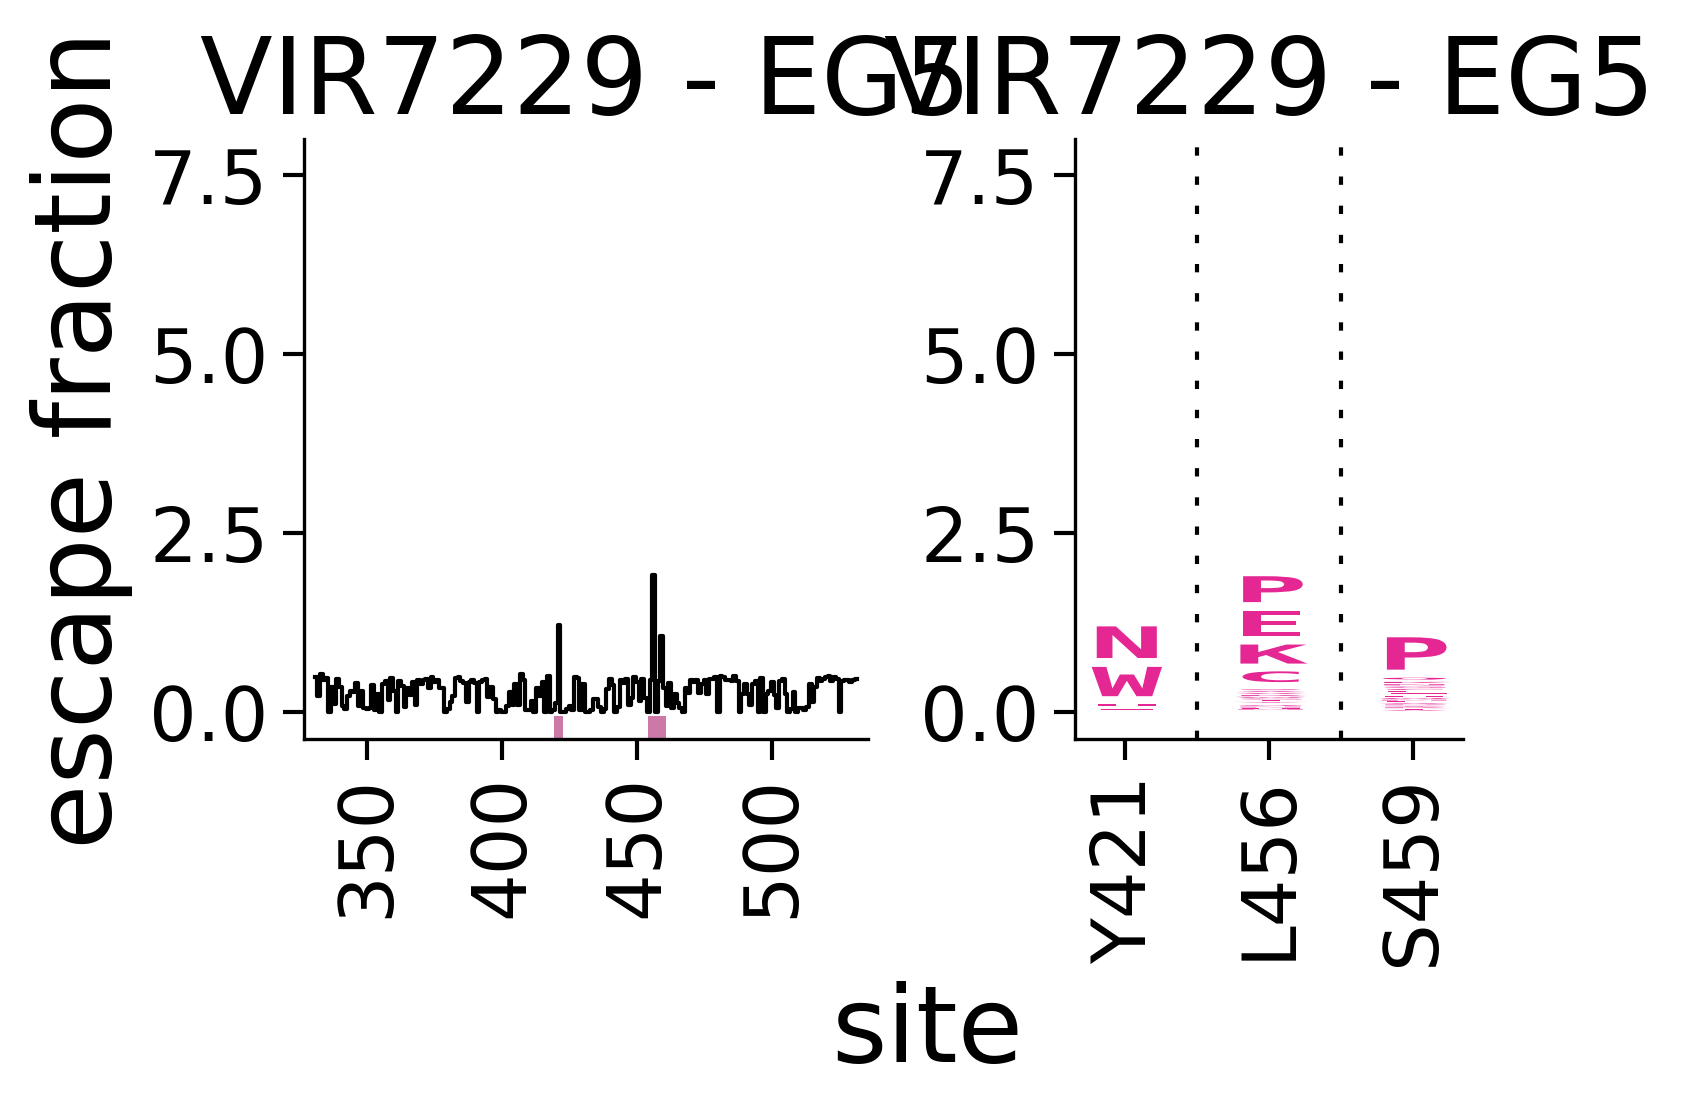


Plotted profile 2 to:
 results/escape_profiles/Omicron_EG5/VIR7229_color_by_bind_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_color_by_bind_stackedlogo.png.


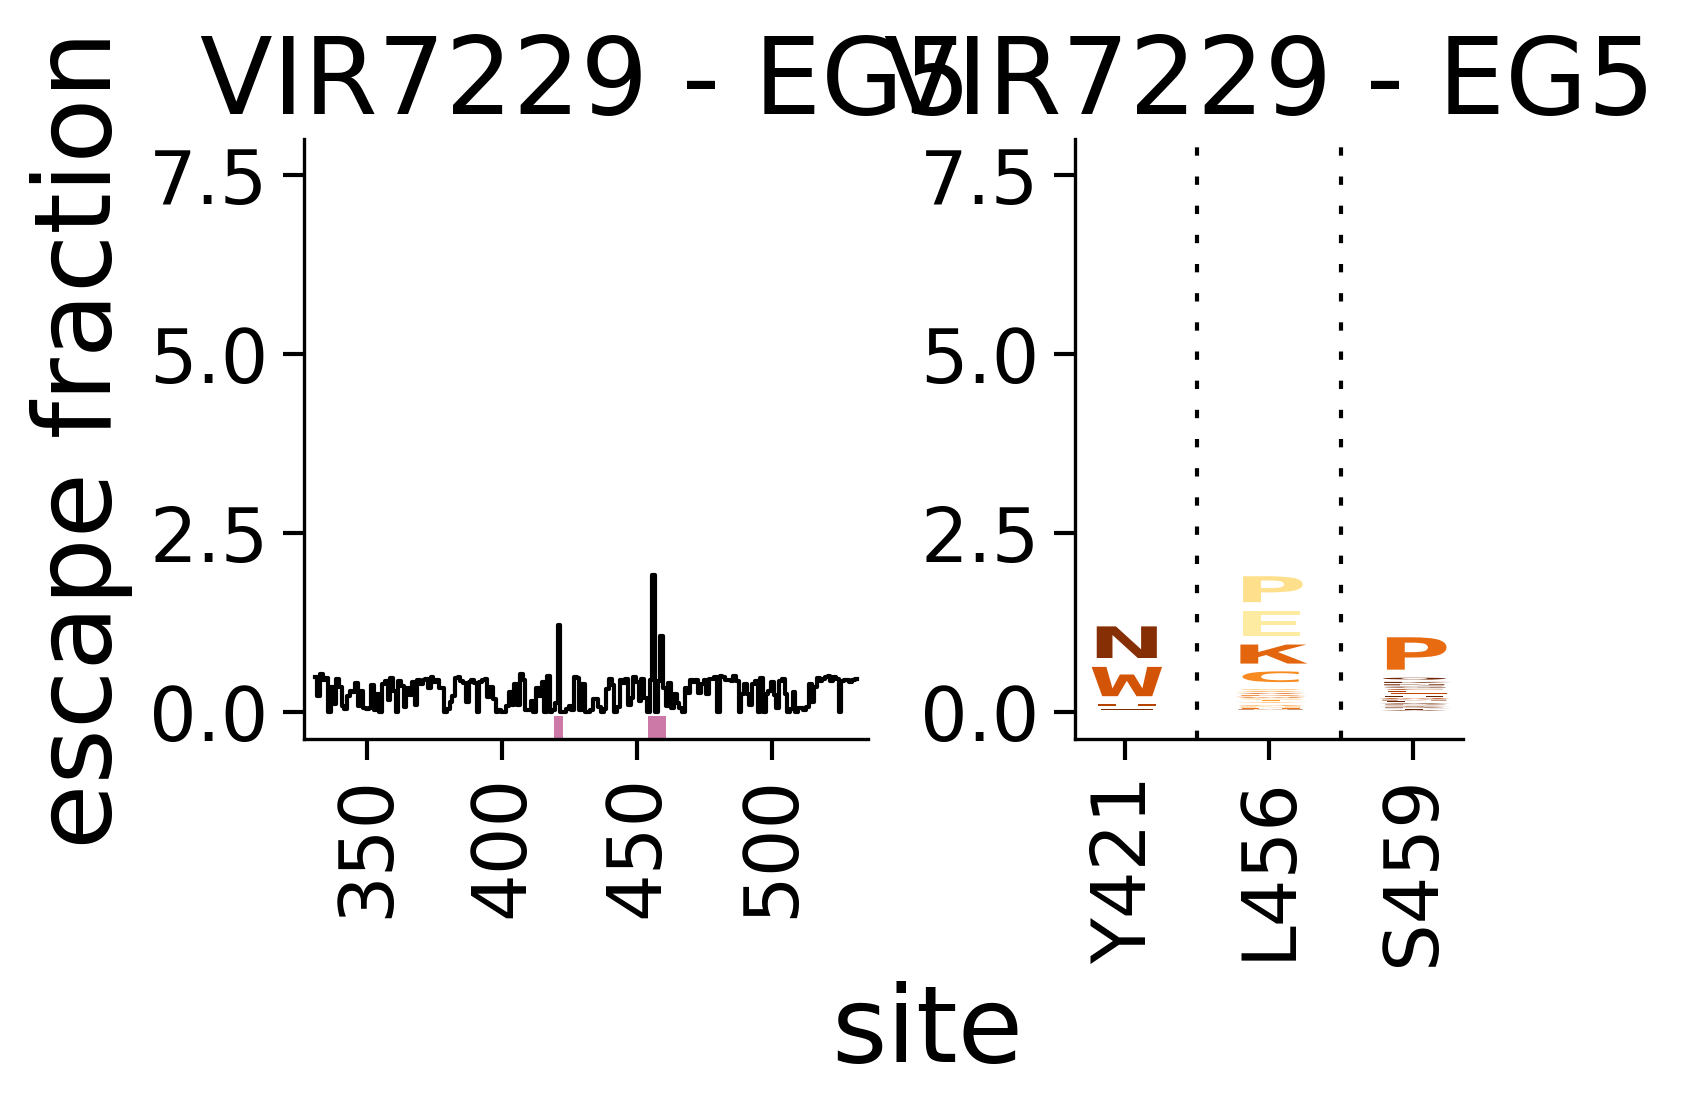


Plotted profile 3 to:
 results/escape_profiles/Omicron_EG5/VIR7229_color_by_expr_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_color_by_expr_stackedlogo.png.


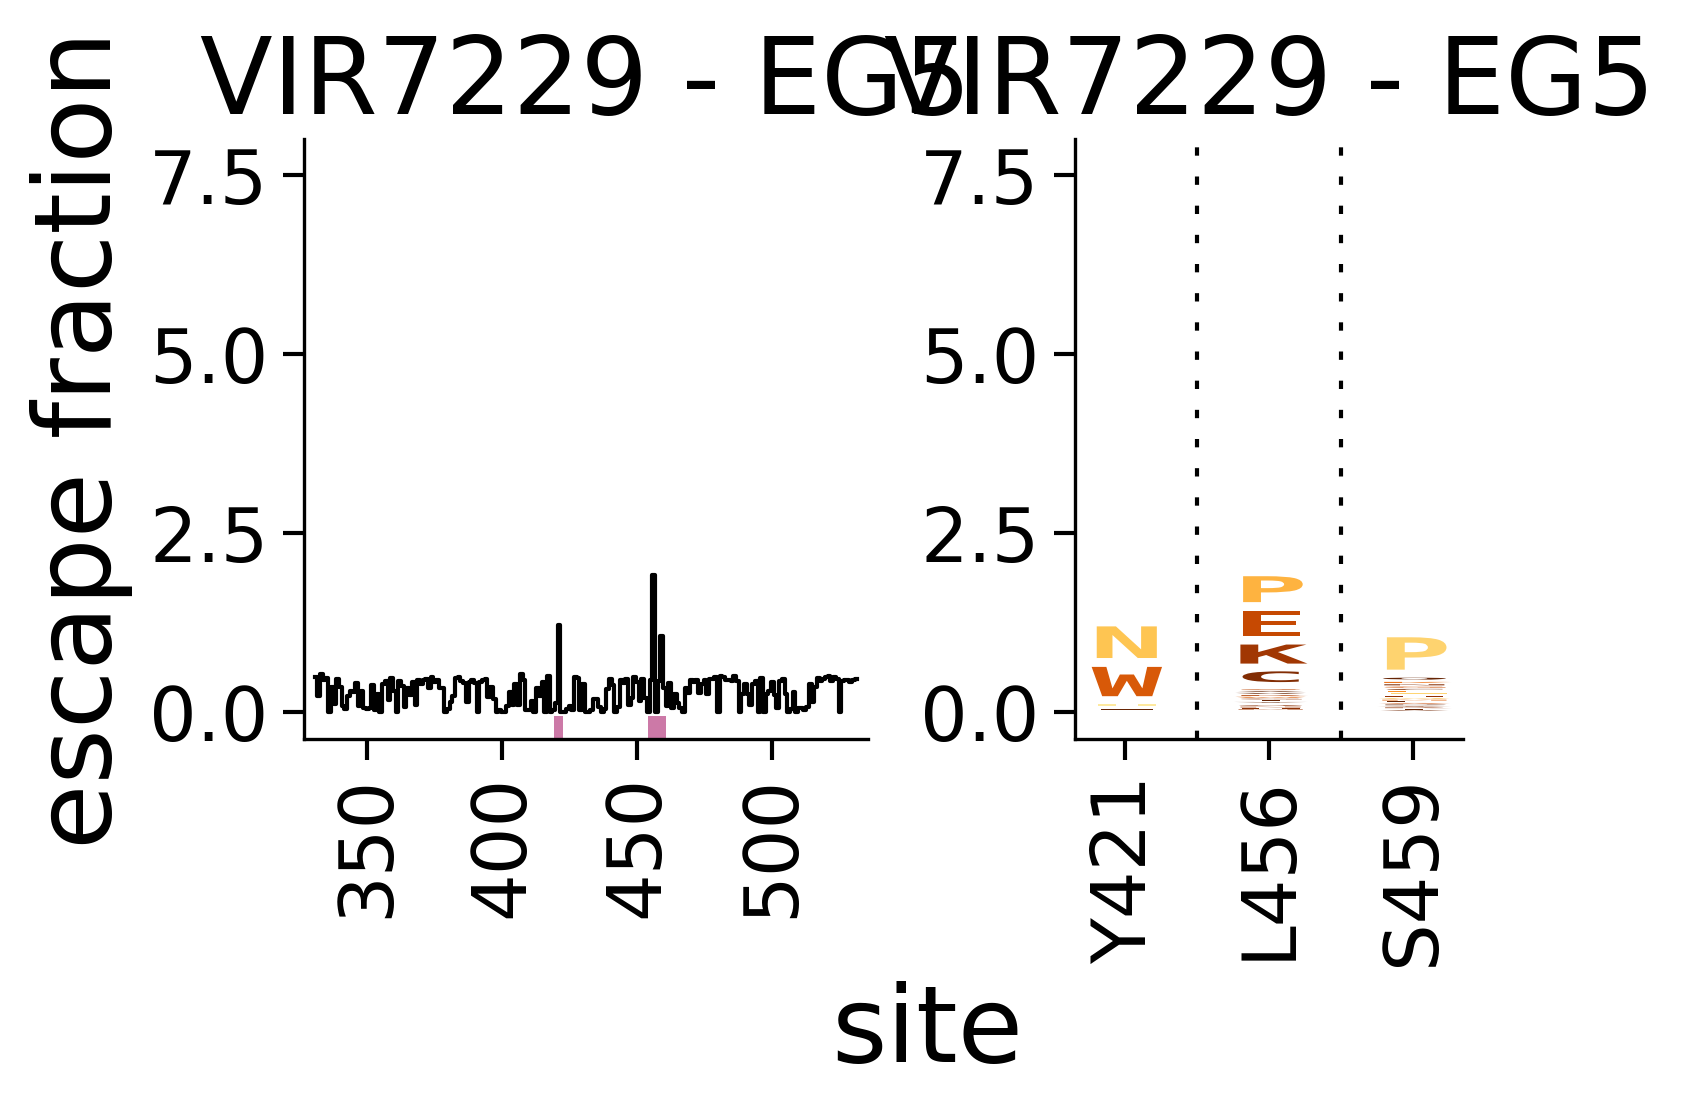


Plotted profile 4 to:
 results/escape_profiles/Omicron_EG5/VIR7229_wide_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_wide_stackedlogo.png.


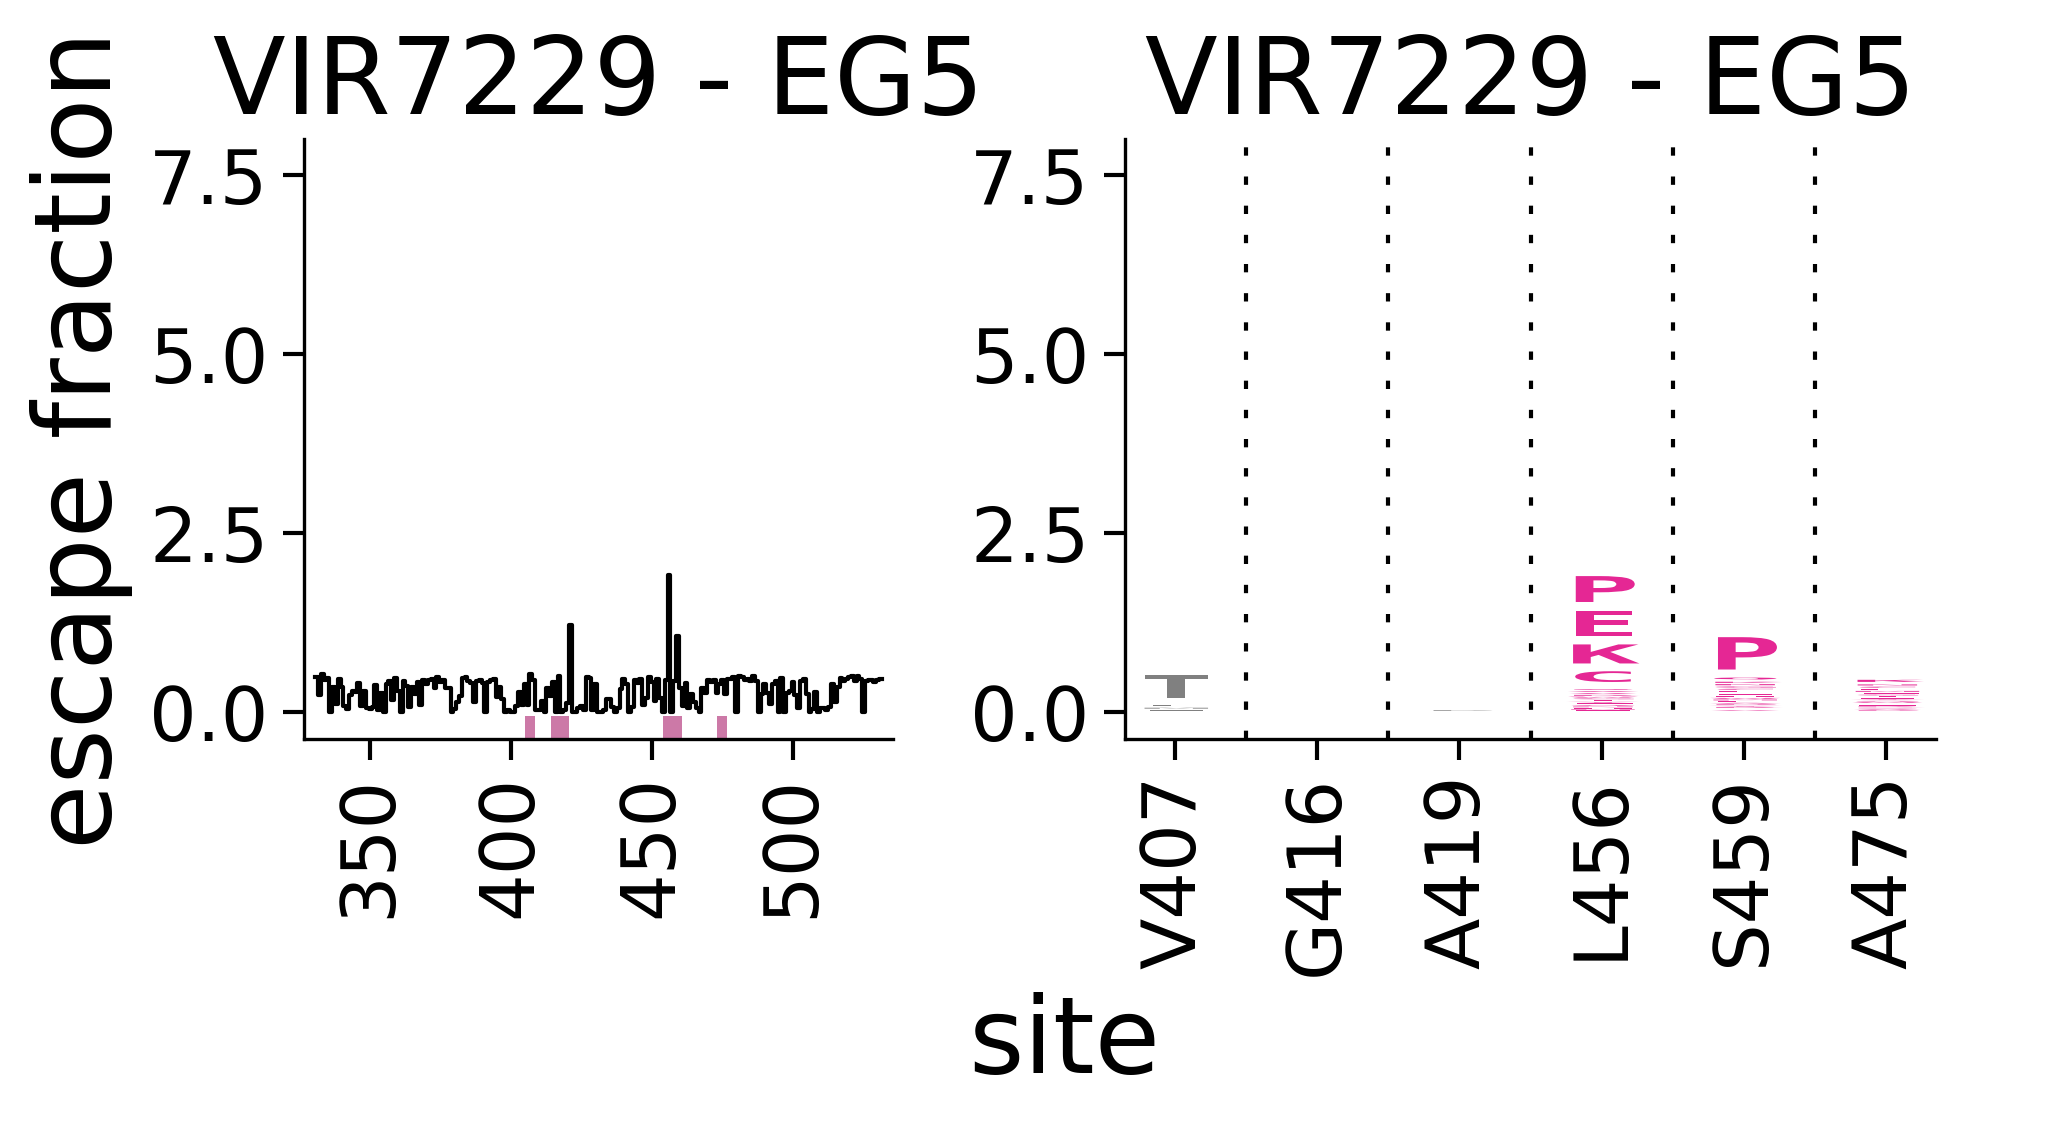


Plotted profile 5 to:
 results/escape_profiles/Omicron_EG5/VIR7229_wide_color_by_bind_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_wide_color_by_bind_stackedlogo.png.


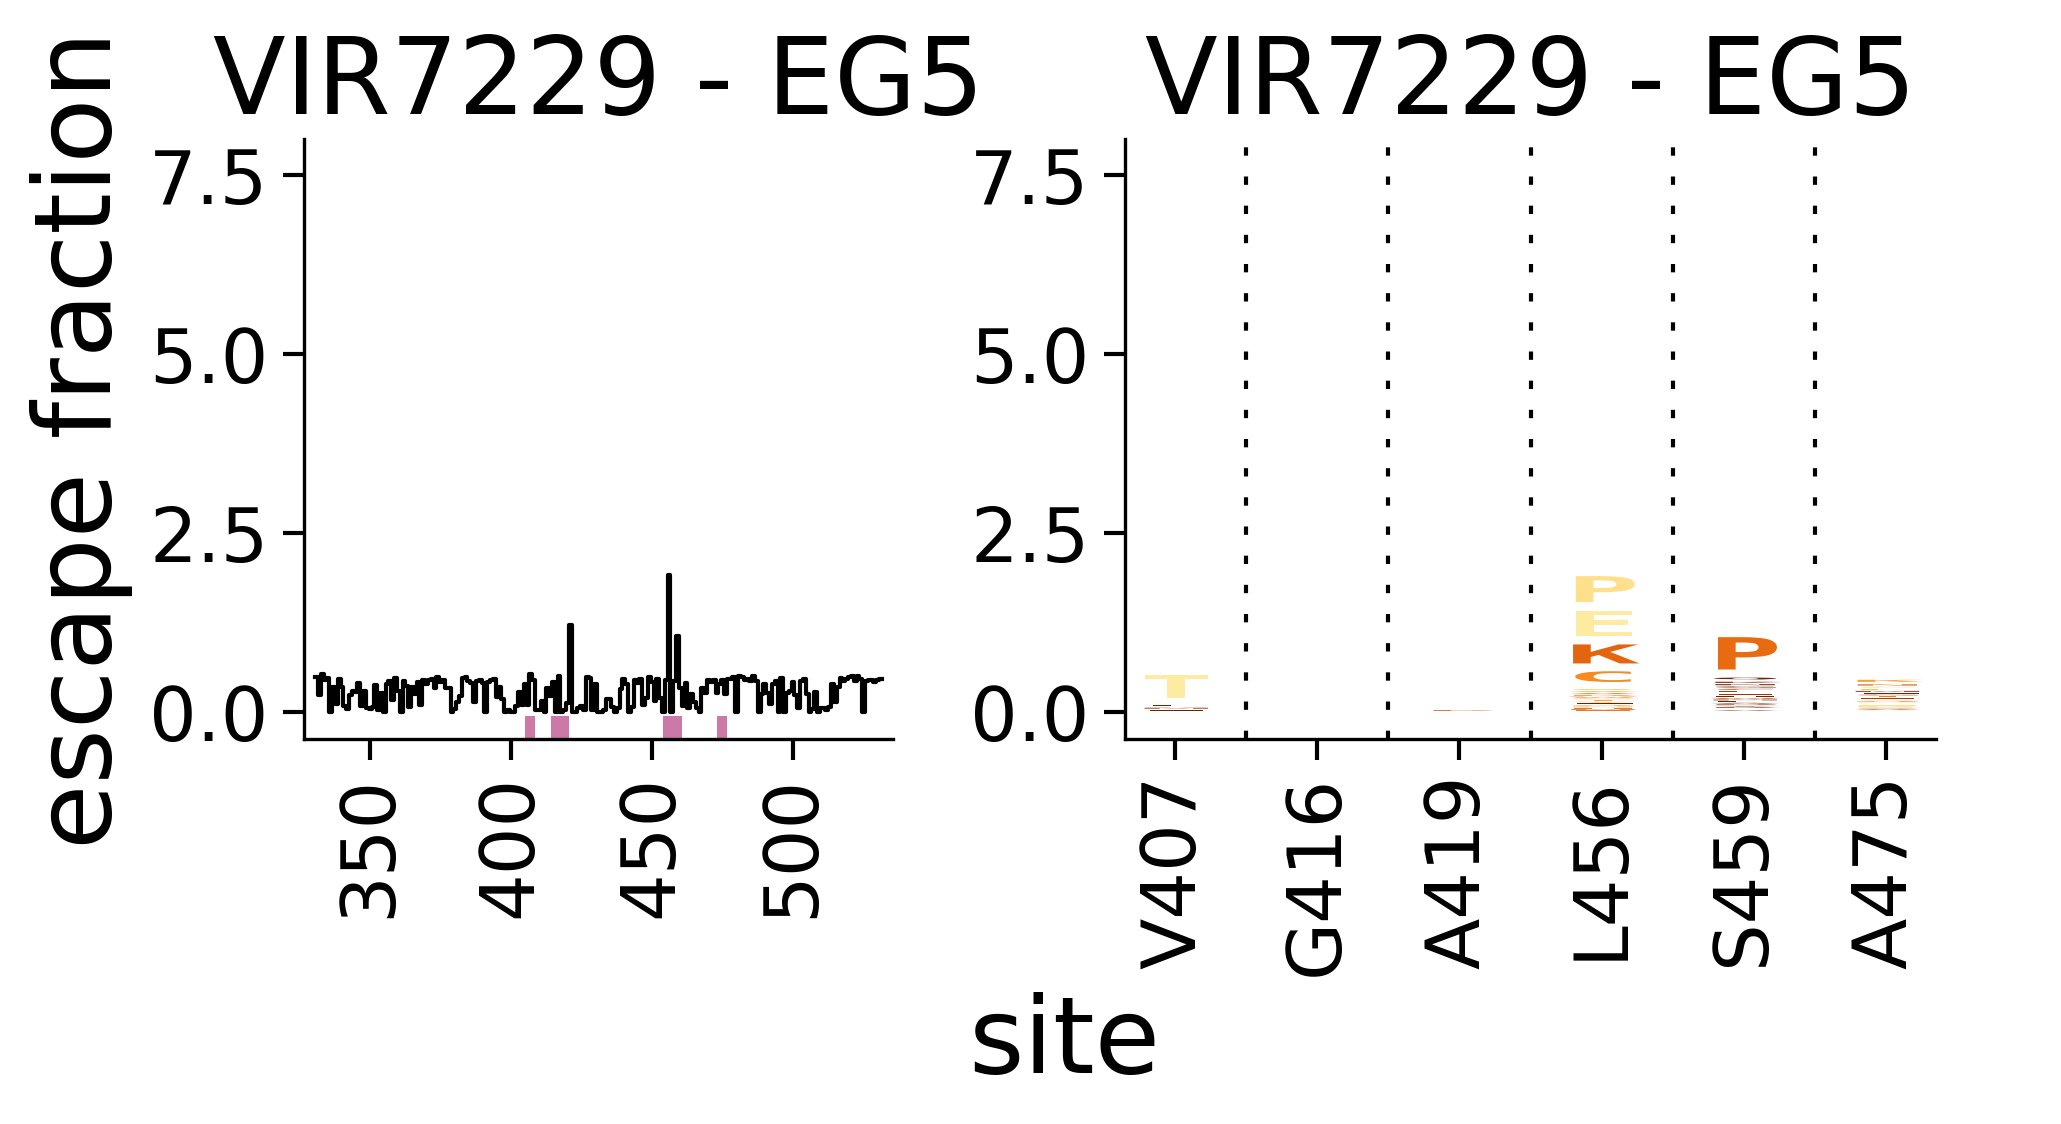


Plotted profile 6 to:
 results/escape_profiles/Omicron_EG5/VIR7229_wide_color_by_expr_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_wide_color_by_expr_stackedlogo.png.


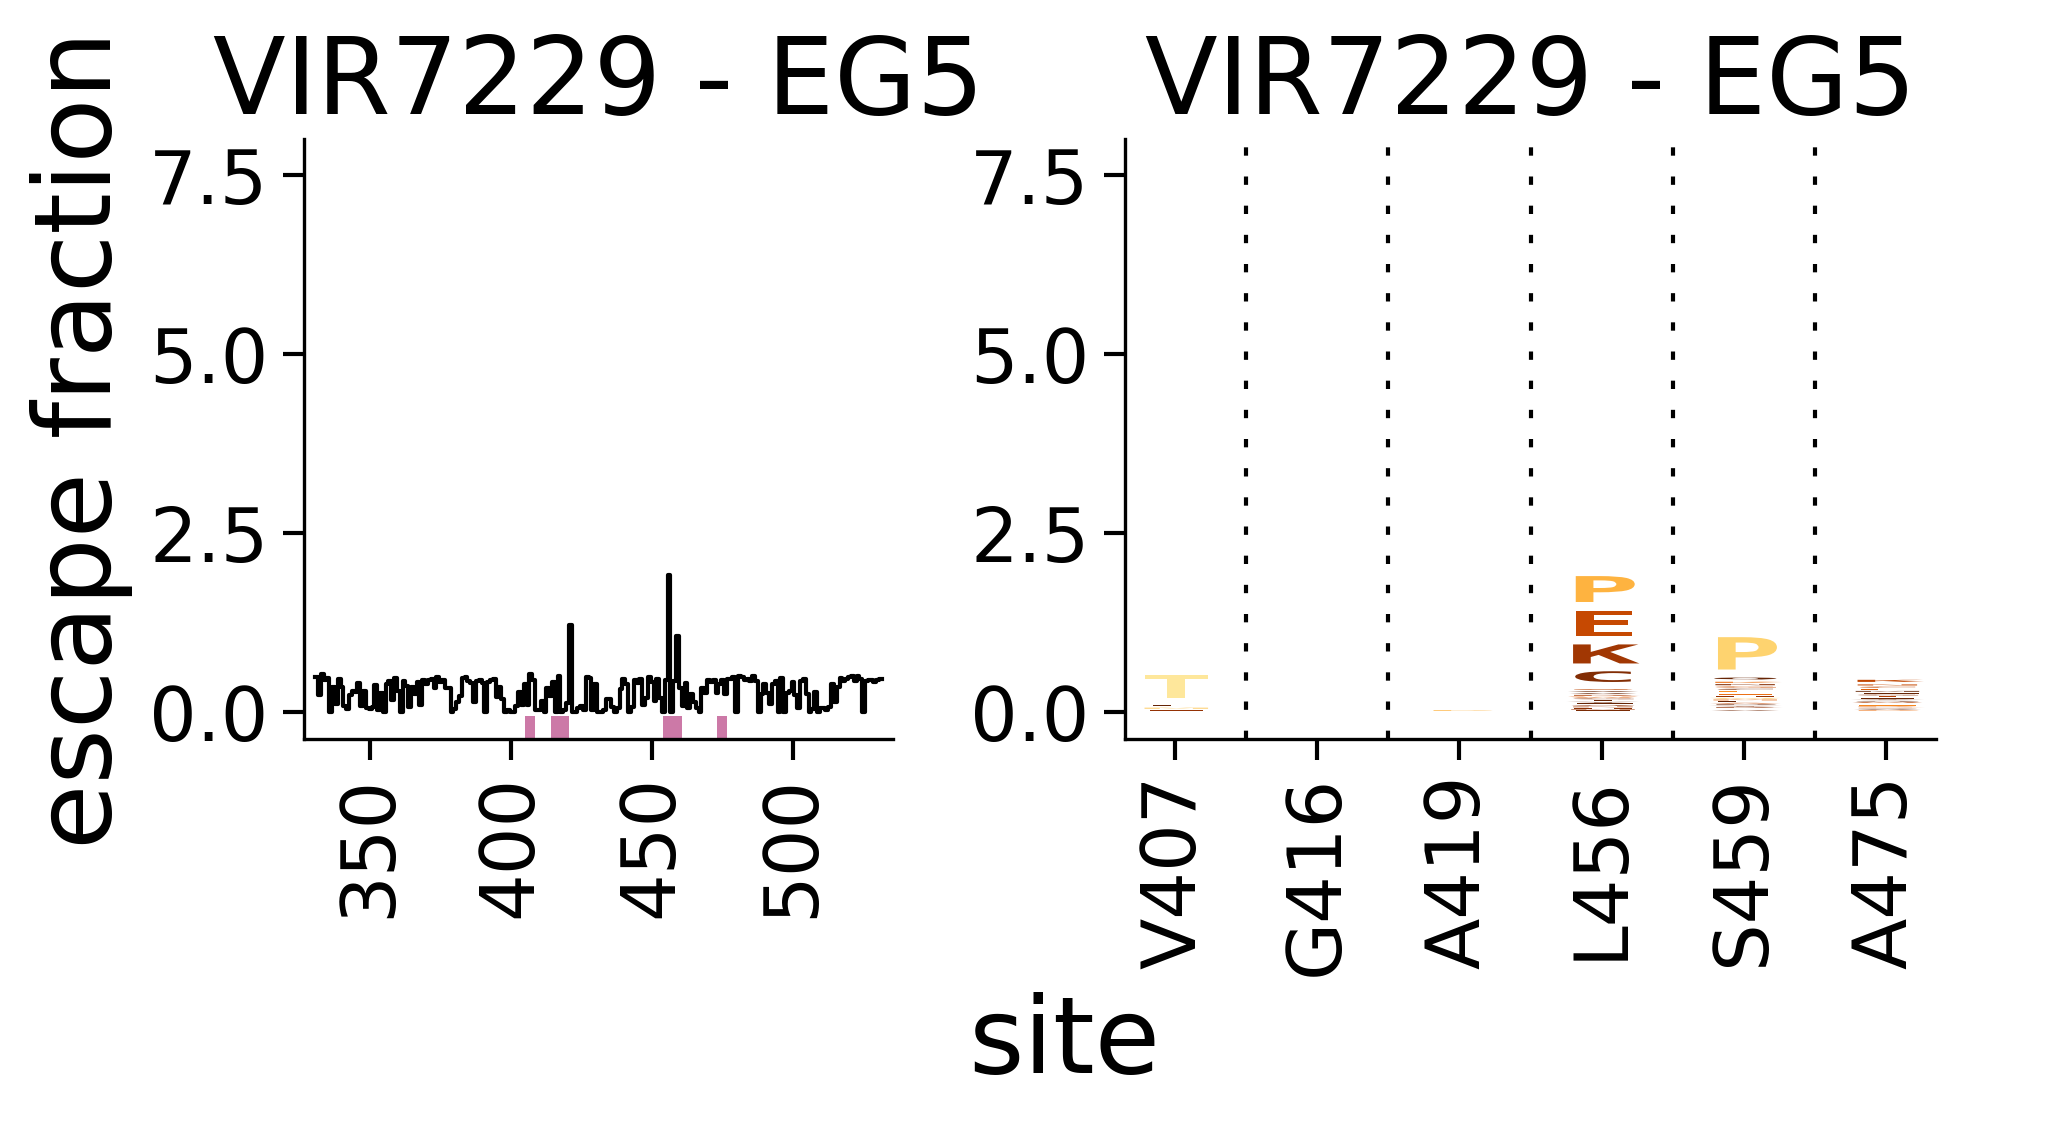


Plotted profile 7 to:
 results/escape_profiles/Omicron_EG5/VIR7229_structural_epitope_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_structural_epitope_stackedlogo.png.


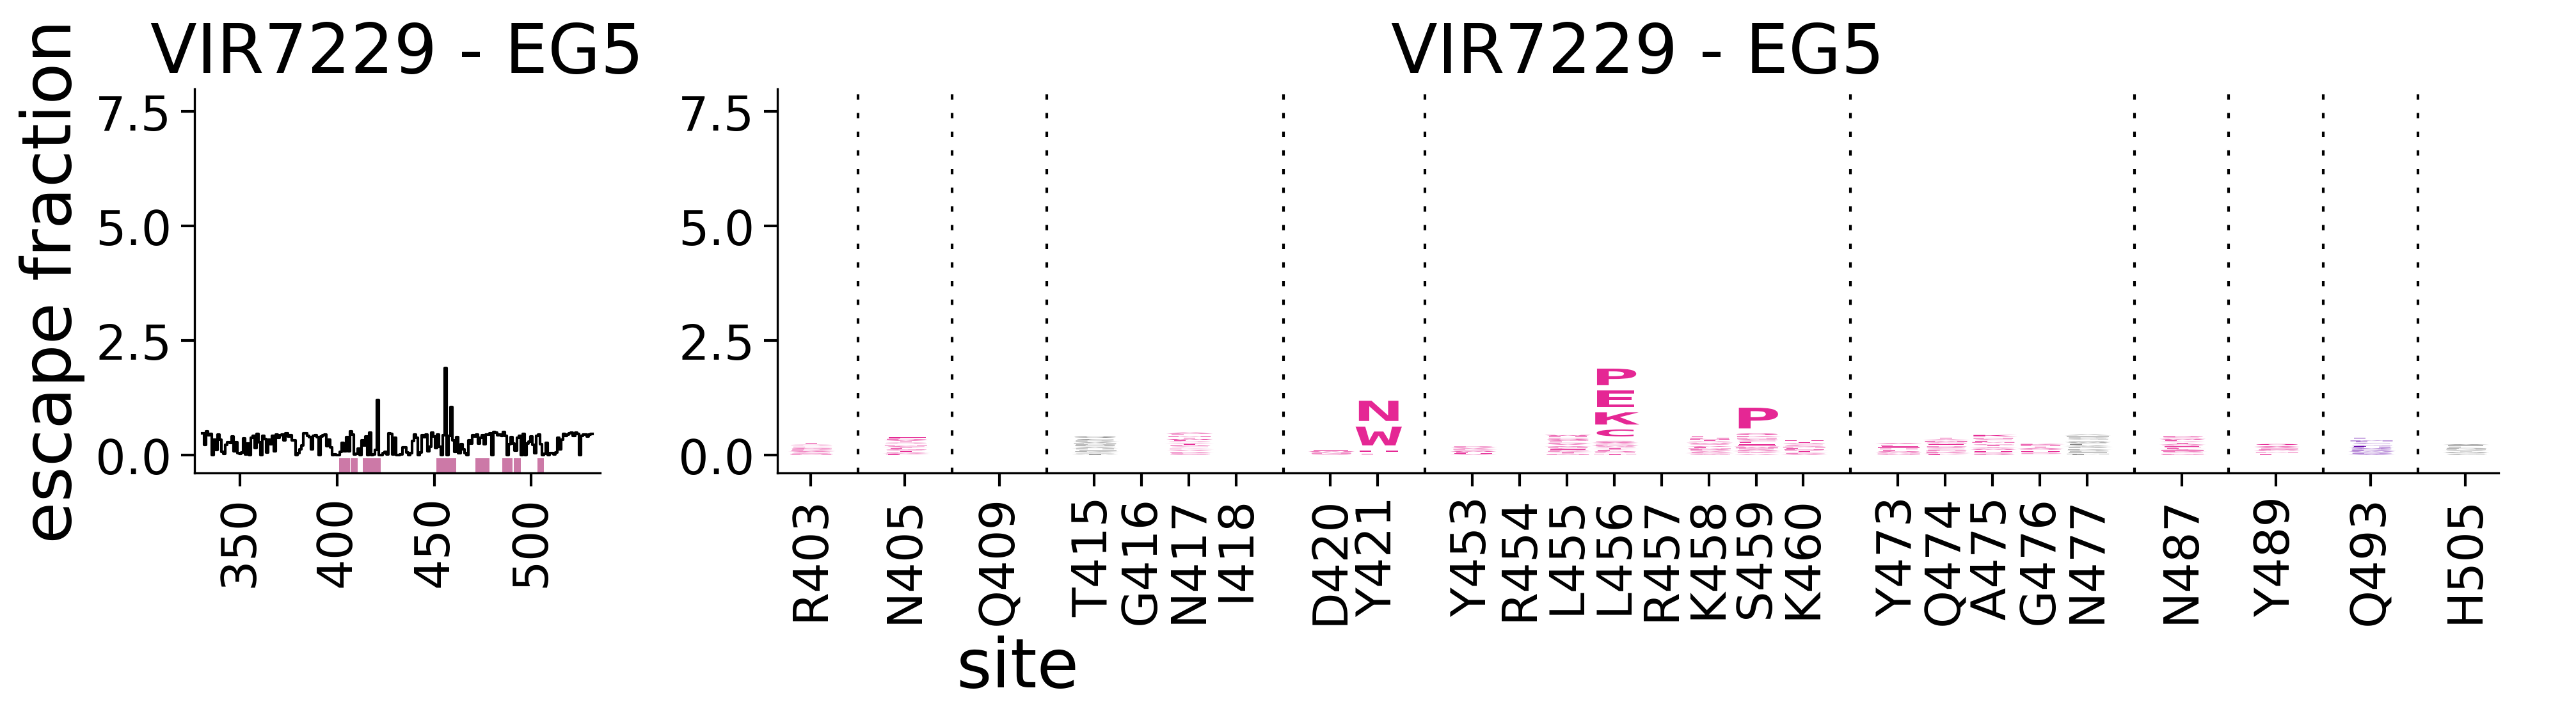


Plotted profile 8 to:
 results/escape_profiles/Omicron_EG5/VIR7229_structural_epitope_color_by_bind_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_structural_epitope_color_by_bind_stackedlogo.png.


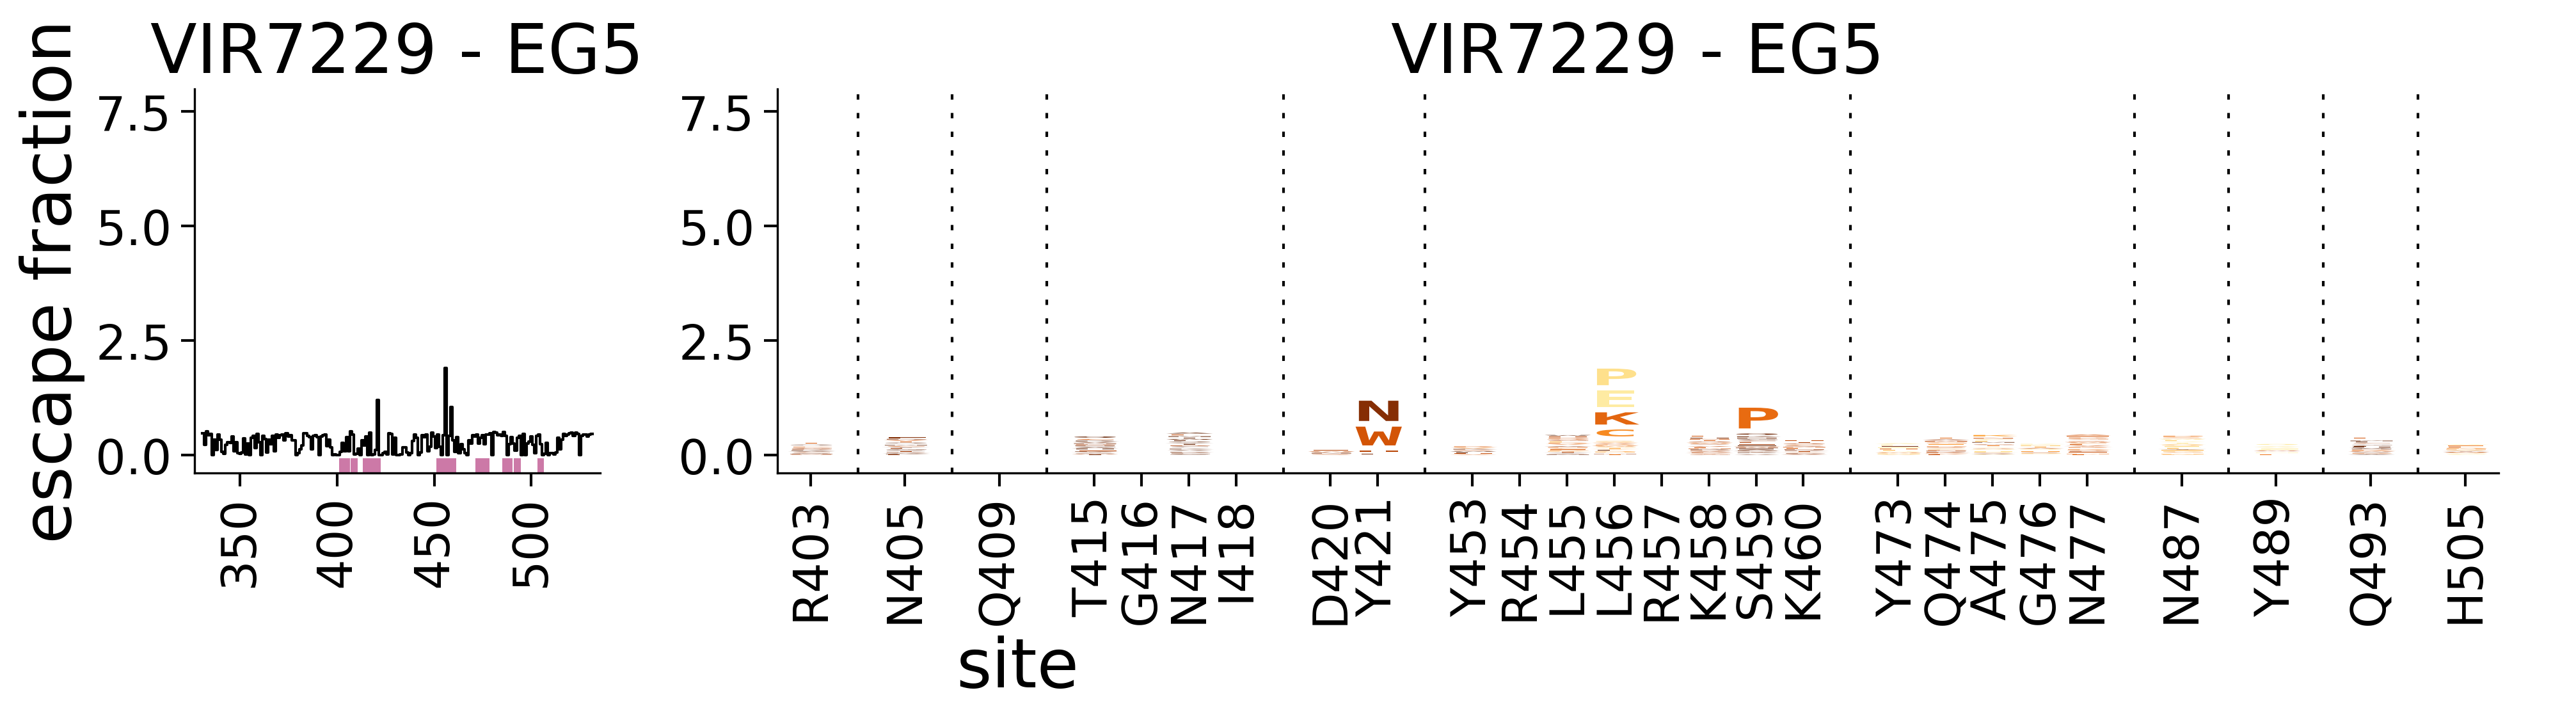


Plotted profile 9 to:
 results/escape_profiles/Omicron_EG5/VIR7229_structural_epitope_color_by_expr_stackedlogo.pdf
 results/escape_profiles/Omicron_EG5/VIR7229_structural_epitope_color_by_expr_stackedlogo.png.


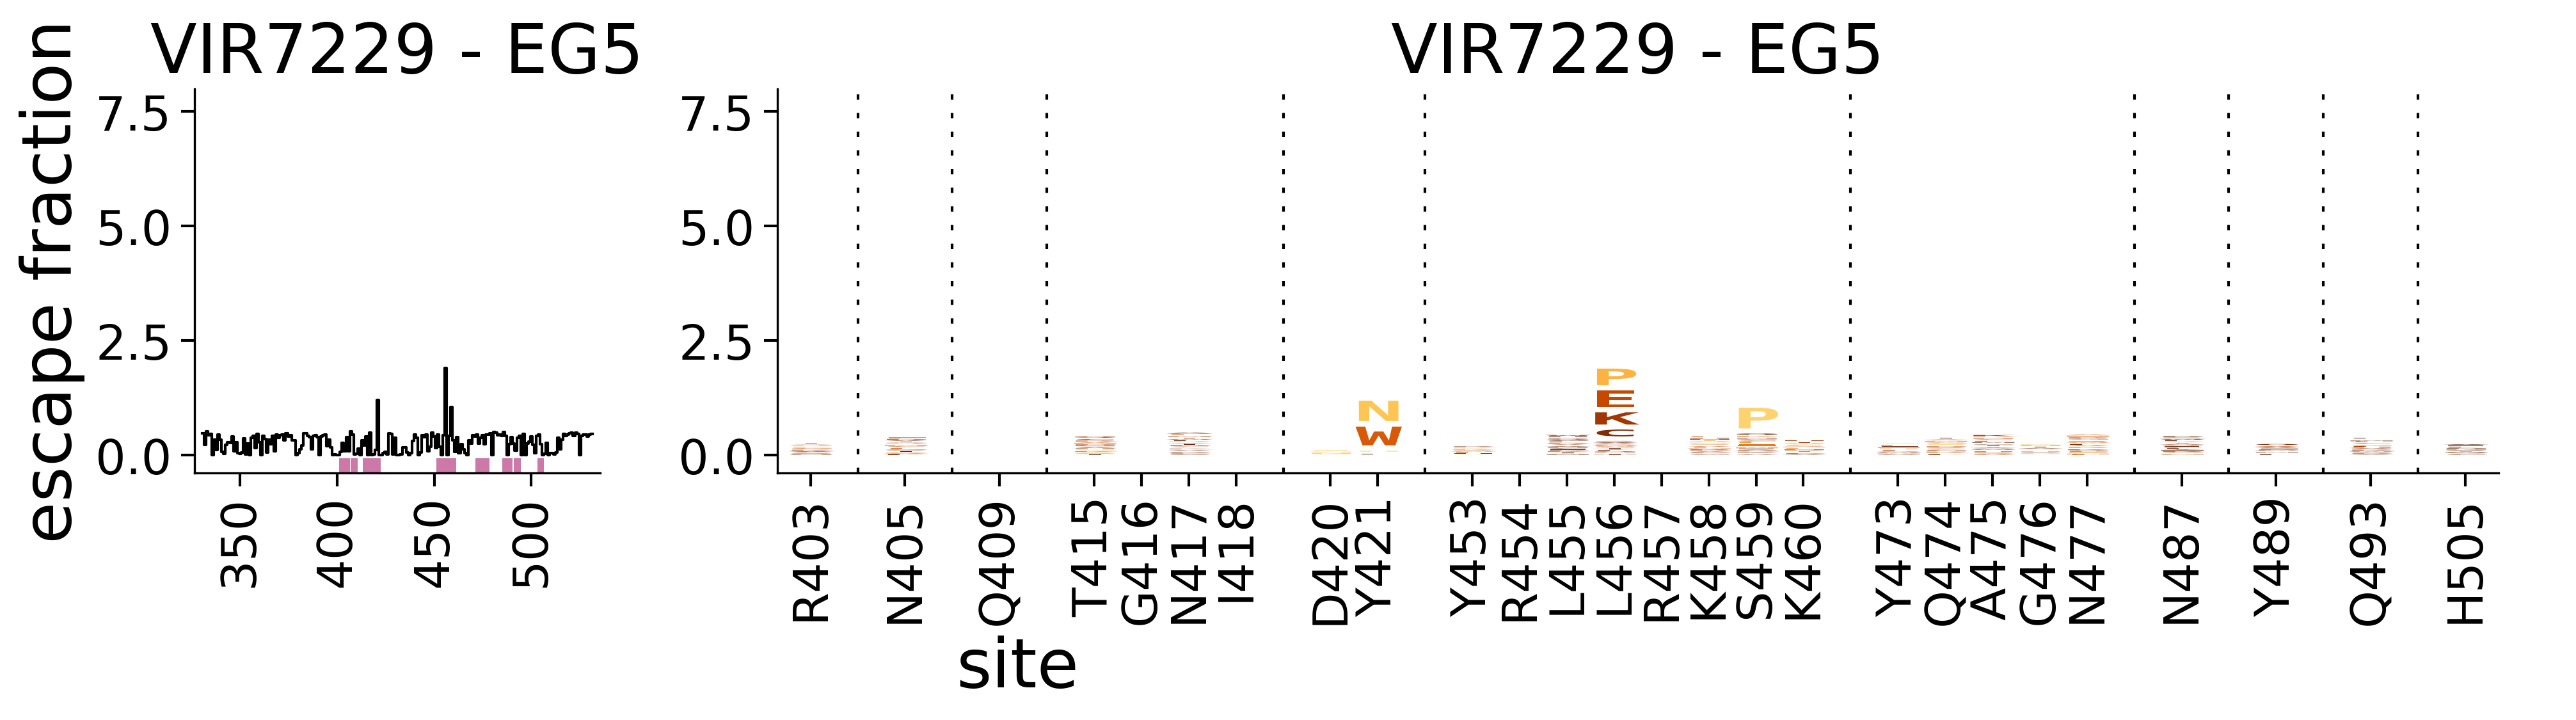

In [13]:
ncpus = min(config['max_cpus'], multiprocessing.cpu_count())
print(f"Drawing {len(draw_profile_tups)} profiles using {ncpus} CPUs...")

with multiprocessing.Pool(ncpus) as pool:
    for i, (tup, (pdffile, pngfile)) in enumerate(zip(draw_profile_tups,
                                                      pool.imap(draw_profile, draw_profile_tups)),
                                                  start=1):
        print(f"\nPlotted profile {i} to:\n {pdffile}\n {pngfile}.")
        draw_line_plot = tup[3]
        assert isinstance(draw_line_plot, bool)
        display(Image(pngfile, width=500 * (1 + int(draw_line_plot))))
        